In [2]:
!pip install roboflow

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="jblXI5MTWDuIfBMWytfI")
project = rf.workspace("khaled-hjb0q").project("tooth-instance-segmentation-vrbtu")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tooth-instance-segmentation-1 in coco:: 100%|██████████| 6252/6252 [00:01<00:00, 4599.25it/s]


In [4]:
import os

path = "/kaggle/working/Tooth-instance-segmentation-1"
for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(".json"):
            print(os.path.join(root, name))

/kaggle/working/Tooth-instance-segmentation-1/train/_annotations.coco.json
/kaggle/working/Tooth-instance-segmentation-1/valid/_annotations.coco.json
/kaggle/working/Tooth-instance-segmentation-1/test/_annotations.coco.json


In [5]:
import json

# Set the path to the COCO annotations file
coco_json_path = "/kaggle/working/Tooth-instance-segmentation-1/train/_annotations.coco.json"

# Load the COCO dataset
with open(coco_json_path, "r") as f:
    coco_data = json.load(f)

# Extract class names and IDs from the categories section
print("Classes found in dataset:")
for cat in coco_data["categories"]:
    print(f"Class ID {cat['id']}: {cat['name']}")


Classes found in dataset:
Class ID 0: teeth-segmentation
Class ID 1: Caries
Class ID 2: Crown
Class ID 3: Crown - bridge
Class ID 4: Filling
Class ID 5: Implant
Class ID 6: Periapical lesion
Class ID 7: Post-screw
Class ID 8: Root Canal Obturation


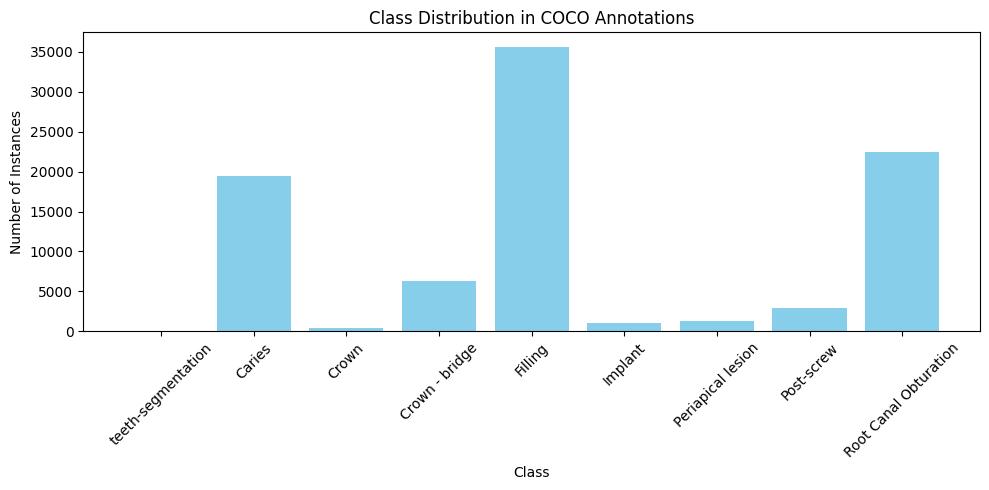

In [6]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Set path to the COCO annotations file
coco_json_path = "/kaggle/working/Tooth-instance-segmentation-1/train/_annotations.coco.json"

# Load COCO data
with open(coco_json_path, "r") as f:
    coco_data = json.load(f)

# Extract class names with IDs
class_names = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

# Count how many times each class_id appears in annotations
class_counts = Counter()
for ann in coco_data["annotations"]:
    class_id = ann["category_id"]
    class_counts[class_id] += 1

# Sort by class ID
sorted_ids = sorted(class_names.keys())
labels = [class_names[cid] for cid in sorted_ids]
values = [class_counts.get(cid, 0) for cid in sorted_ids]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45)
plt.title("Class Distribution in COCO Annotations")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.tight_layout()
plt.show()


In [7]:
for cat in coco_data["categories"]:
    print(f"-{cat['name']}-")


-teeth-segmentation-
-Caries-
-Crown-
-Crown - bridge-
-Filling-
-Implant-
-Periapical lesion-
-Post-screw-
-Root Canal Obturation-


In [8]:
import json
import os

def remove_classes_and_remap(coco_json_path, output_json_path, classes_to_remove):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Remove unwanted classes
    original_categories = coco_data["categories"]
    filtered_categories = [cat for cat in original_categories if cat["name"] not in classes_to_remove]

    # Create old_id -> new_id mapping
    old_to_new_id = {}
    new_categories = []
    new_id = 0
    for cat in filtered_categories:
        old_to_new_id[cat["id"]] = new_id
        cat["id"] = new_id
        new_categories.append(cat)
        new_id += 1

    # Update annotations
    filtered_annotations = []
    for ann in coco_data["annotations"]:
        if ann["category_id"] in old_to_new_id:
            ann["category_id"] = old_to_new_id[ann["category_id"]]
            filtered_annotations.append(ann)

    # Replace data
    coco_data["categories"] = new_categories
    coco_data["annotations"] = filtered_annotations

    with open(output_json_path, 'w') as f:
        json.dump(coco_data, f)

    print(f"Cleaned and saved: {output_json_path}")


# Run on all 3 splits
base_path = "/kaggle/working/Tooth-instance-segmentation-1"
classes_to_remove = ["teeth-segmentation", "Crown", "Periapical lesion", "Implant"]

for split in ["train", "valid", "test"]:
    input_path = f"{base_path}/{split}/_annotations.coco.json"
    output_path = f"{base_path}/{split}/_annotations.cleaned.coco.json"
    remove_classes_and_remap(input_path, output_path, classes_to_remove)


Cleaned and saved: /kaggle/working/Tooth-instance-segmentation-1/train/_annotations.cleaned.coco.json
Cleaned and saved: /kaggle/working/Tooth-instance-segmentation-1/valid/_annotations.cleaned.coco.json
Cleaned and saved: /kaggle/working/Tooth-instance-segmentation-1/test/_annotations.cleaned.coco.json


In [10]:
import json
from collections import Counter

# Path to the cleaned COCO annotations file
json_path = "/kaggle/working/Tooth-instance-segmentation-1/train/_annotations.cleaned.coco.json"

# Load the annotation data
with open(json_path, 'r') as f:
    data = json.load(f)

# Extract class names by ID
class_names = {cat["id"]: cat["name"] for cat in data["categories"]}

# Count instances per class ID from annotations
class_counts = Counter()
for ann in data["annotations"]:
    class_id = ann["category_id"]
    class_counts[class_id] += 1

# Print class distribution
print("Class ID | Class Name              | Count")
print("--------------------------------------------")
for cls_id in sorted(class_counts):
    name = class_names.get(cls_id, "Unknown")
    count = class_counts[cls_id]
    print(f"{cls_id:<8} | {name:<23} | {count}")


Class ID | Class Name              | Count
--------------------------------------------
0        | Caries                  | 19422
1        | Crown - bridge          | 6272
2        | Filling                 | 35652
3        | Post-screw              | 2962
4        | Root Canal Obturation   | 22414


In [11]:
import json

for split in ["train", "valid", "test"]:
    path = f"/kaggle/working/Tooth-instance-segmentation-1/{split}/_annotations.cleaned.coco.json"
    with open(path, "r") as f:
        data = json.load(f)
    
    class_names = {cat["id"]: cat["name"] for cat in data["categories"]}
    
    print(f"\nClasses in {split}:")
    for i in sorted(class_names):
        print(f"ID: {i} - Name: {class_names[i]}")



Classes in train:
ID: 0 - Name: Caries
ID: 1 - Name: Crown - bridge
ID: 2 - Name: Filling
ID: 3 - Name: Post-screw
ID: 4 - Name: Root Canal Obturation

Classes in valid:
ID: 0 - Name: Caries
ID: 1 - Name: Crown - bridge
ID: 2 - Name: Filling
ID: 3 - Name: Post-screw
ID: 4 - Name: Root Canal Obturation

Classes in test:
ID: 0 - Name: Caries
ID: 1 - Name: Crown - bridge
ID: 2 - Name: Filling
ID: 3 - Name: Post-screw
ID: 4 - Name: Root Canal Obturation


In [13]:
import json
import os
from tqdm import tqdm

def convert_coco_to_yolo_segmentation(coco_json_path, output_labels_dir):
    with open(coco_json_path) as f:
        coco_data = json.load(f)

    # Map image_id to file_name and image size
    image_id_map = {
        img["id"]: {"file_name": img["file_name"], "width": img["width"], "height": img["height"]}
        for img in coco_data["images"]
    }

    # Map category_id to index starting from 0
    category_id_map = {cat["id"]: cat["id"] for cat in coco_data["categories"]}

    # Prepare output folder
    os.makedirs(output_labels_dir, exist_ok=True)

    # Group annotations by image
    annotations_by_image = {}
    for ann in coco_data["annotations"]:
        img_id = ann["image_id"]
        annotations_by_image.setdefault(img_id, []).append(ann)

    for img_id, anns in tqdm(annotations_by_image.items(), desc="Converting"):
        img_info = image_id_map[img_id]
        img_width = img_info["width"]
        img_height = img_info["height"]
        file_stem = os.path.splitext(img_info["file_name"])[0]
        label_path = os.path.join(output_labels_dir, file_stem + ".txt")

        lines = []

        for ann in anns:
            cls_id = category_id_map[ann["category_id"]]
            segmentation = ann["segmentation"]

            # Skip if it's RLE (not polygon)
            if not isinstance(segmentation, list):
                continue

            for seg in segmentation:
                normalized_coords = []
                for i in range(0, len(seg), 2):
                    x = seg[i] / img_width
                    y = seg[i + 1] / img_height
                    normalized_coords.extend([x, y])

                line = f"{cls_id} " + " ".join([f"{x:.6f}" for x in normalized_coords])
                lines.append(line)

        with open(label_path, "w") as f:
            f.write("\n".join(lines))

    print(f"\n Conversion complete! Labels saved in: {output_labels_dir}")


In [14]:
convert_coco_to_yolo_segmentation(
    "/kaggle/working/Tooth-instance-segmentation-1/train/_annotations.cleaned.coco.json",
    "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
)

convert_coco_to_yolo_segmentation(
    "/kaggle/working/Tooth-instance-segmentation-1/valid/_annotations.cleaned.coco.json",
    "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
)

convert_coco_to_yolo_segmentation(
    "/kaggle/working/Tooth-instance-segmentation-1/test/_annotations.cleaned.coco.json",
    "/kaggle/working/Tooth-instance-segmentation-1/test/labels"
)


Converting: 100%|██████████| 5134/5134 [00:01<00:00, 3508.25it/s]



 Conversion complete! Labels saved in: /kaggle/working/Tooth-instance-segmentation-1/train/labels


Converting: 100%|██████████| 728/728 [00:00<00:00, 3749.08it/s]



 Conversion complete! Labels saved in: /kaggle/working/Tooth-instance-segmentation-1/valid/labels


Converting: 100%|██████████| 371/371 [00:00<00:00, 3831.41it/s]


 Conversion complete! Labels saved in: /kaggle/working/Tooth-instance-segmentation-1/test/labels


In [15]:
import os
import shutil

def move_images_to_subfolder(set_path):
    image_dir = os.path.join(set_path, "images")
    os.makedirs(image_dir, exist_ok=True)

    for file in os.listdir(set_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            old_path = os.path.join(set_path, file)
            new_path = os.path.join(image_dir, file)
            shutil.move(old_path, new_path)

    print(f" Moved images to {image_dir}")

# Apply for train/val/test
move_images_to_subfolder("/kaggle/working/Tooth-instance-segmentation-1/train")
move_images_to_subfolder("/kaggle/working/Tooth-instance-segmentation-1/valid")
move_images_to_subfolder("/kaggle/working/Tooth-instance-segmentation-1/test")

 Moved images to /kaggle/working/Tooth-instance-segmentation-1/train/images
 Moved images to /kaggle/working/Tooth-instance-segmentation-1/valid/images
 Moved images to /kaggle/working/Tooth-instance-segmentation-1/test/images


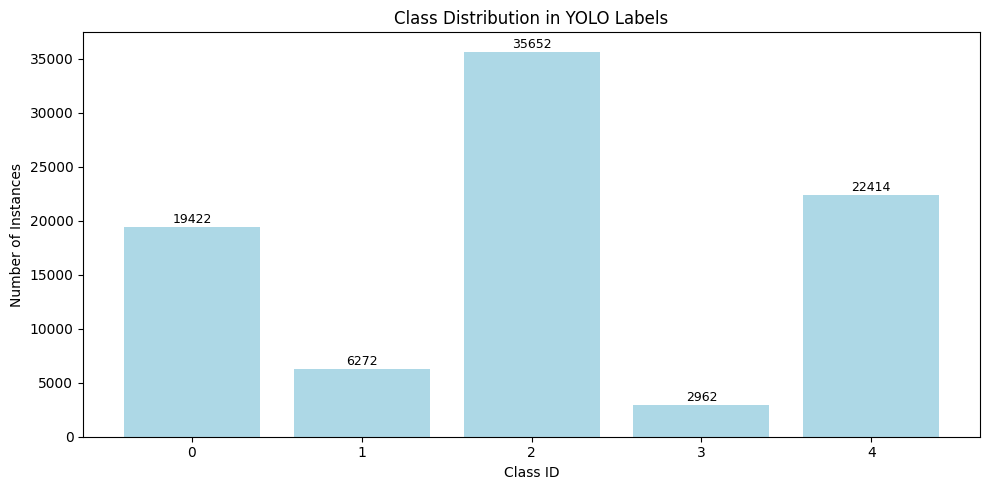


Class Index | Count
---------------------
0           | 19422
1           | 6272
2           | 35652
3           | 2962
4           | 22414


In [16]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Path to YOLO label directory
labels_dir = "/kaggle/working/Tooth-instance-segmentation-1/train/labels"

# Count instances of each class from label files
class_counts = Counter()
for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(labels_dir, filename), "r") as f:
            for line in f:
                if line.strip():
                    cls_id = int(line.strip().split()[0])
                    class_counts[cls_id] += 1

# Sort by class ID
sorted_counts = sorted(class_counts.items())

# Prepare data
class_ids = [item[0] for item in sorted_counts]
counts = [item[1] for item in sorted_counts]

# Plot the bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar([str(cls_id) for cls_id in class_ids], counts, color="lightblue")
plt.title("Class Distribution in YOLO Labels")
plt.xlabel("Class ID")
plt.ylabel("Number of Instances")
plt.xticks(rotation=0)

# Annotate each bar with count
for bar, value in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, str(value),
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print as table outside the image
print("\nClass Index | Count")
print("---------------------")
for cls_id, count in sorted_counts:
    print(f"{cls_id:<11} | {count}")


In [17]:
import os

yaml_path = "/kaggle/working/Tooth-instance-segmentation-1/data.yaml"

if os.path.exists(yaml_path):
    print("data.yaml exists.")
else:
    print("data.yaml not found.")


data.yaml not found.


In [18]:
import os
import json
import yaml

# Path to your cleaned COCO JSON (train file)
json_path = "/kaggle/working/Tooth-instance-segmentation-1/train/_annotations.cleaned.coco.json"

# Output path for .yaml file
yaml_path = "/kaggle/working/Tooth-instance-segmentation-1/dataset.yaml"

# Load COCO JSON to extract class names
with open(json_path, 'r') as f:
    coco_data = json.load(f)

# Extract class names
class_names = [cat["name"] for cat in sorted(coco_data["categories"], key=lambda x: x["id"])]

# Compose .yaml content
data_yaml = {
    "train": "/kaggle/working/Tooth-instance-segmentation-1/train/images",
    "val": "/kaggle/working/Tooth-instance-segmentation-1/valid/images",
    "test": "/kaggle/working/Tooth-instance-segmentation-1/test/images",
    "nc": len(class_names),
    "names": class_names
}

# Save to .yaml
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print(f".yaml file created and saved to: {yaml_path}")


.yaml file created and saved to: /kaggle/working/Tooth-instance-segmentation-1/dataset.yaml


In [22]:
import yaml

yaml_path = "/kaggle/working/Tooth-instance-segmentation-1/data.yaml"

# Load and print the YAML file
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

print("YAML File Content:")
for key, value in data.items():
    print(f"{key}: {value}")


YAML File Content:
train: /kaggle/working/Tooth-instance-segmentation-1/train/images
val: /kaggle/working/Tooth-instance-segmentation-1/valid/images
test: /kaggle/working/Tooth-instance-segmentation-1/test/images
nc: 5
names: ['Caries', 'Crown - bridge', 'Filling', 'Post-screw', 'Root Canal Obturation']


In [23]:
import os

def check_missing_labels(images_dir, labels_dir):
    image_files = sorted([
        os.path.splitext(f)[0] for f in os.listdir(images_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    
    label_files = sorted([
        os.path.splitext(f)[0] for f in os.listdir(labels_dir)
        if f.lower().endswith('.txt')
    ])

    image_set = set(image_files)
    label_set = set(label_files)

    missing_labels = image_set - label_set
    missing_images = label_set - image_set

    print(f"\n Directory: {os.path.basename(images_dir)}")
    print(f"Total Images: {len(image_set)}")
    print(f"Total Labels: {len(label_set)}")
    print(f"Images without labels: {len(missing_labels)}")
    print(f"Labels without images: {len(missing_images)}")

    if missing_labels:
        print("  - Sample of images without labels:", list(missing_labels)[:5])
    if missing_images:
        print("  - Sample of labels without images:", list(missing_images)[:5])

# Run checks
check_missing_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/train/images",
    "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
)

check_missing_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/valid/images",
    "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
)

check_missing_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/test/images",
    "/kaggle/working/Tooth-instance-segmentation-1/test/labels"
)



 Directory: images
Total Images: 5144
Total Labels: 5134
Images without labels: 10
Labels without images: 0
  - Sample of images without labels: ['periodontal_44_png_jpg.rf.1a9da203c30169f7aa8d3c71d90ee433', 'periodontal_44_png_jpg.rf.8f6ab99158603fbd356ffebd23f8b3ab', 'periodontal_44_png_jpg.rf.5355e67ace18ed3a311c97773f2fee9c', 'periodontal_44_png_jpg.rf.feb21dcdc30c092cd2547a0de6afc1ab', 'periodontal_44_png_jpg.rf.beec1f129323c47fde243cfb9b4ebf29']

 Directory: images
Total Images: 729
Total Labels: 728
Images without labels: 1
Labels without images: 0
  - Sample of images without labels: ['periodontal_44_png_jpg.rf.4973ad5110eadb9d1ac0a736b22de692']

 Directory: images
Total Images: 371
Total Labels: 371
Images without labels: 0
Labels without images: 0


In [ ]:
import os

def delete_images_without_labels(images_dir, labels_dir):
    image_files = sorted([
        os.path.splitext(f)[0] for f in os.listdir(images_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    
    label_files = sorted([
        os.path.splitext(f)[0] for f in os.listdir(labels_dir)
        if f.lower().endswith('.txt')
    ])

    image_set = set(image_files)
    label_set = set(label_files)

    missing_labels = image_set - label_set

    print(f"\nFound {len(missing_labels)} images without labels in {os.path.basename(images_dir)}")

    for img_name in missing_labels:
        deleted = False
        for ext in ['.jpg', '.jpeg', '.png']:
            img_path = os.path.join(images_dir, img_name + ext)
            if os.path.exists(img_path):
                os.remove(img_path)
                print(f"Deleted: {img_path}")
                deleted = True
        if not deleted:
            print(f" File not found for deletion: {img_name}")

# Apply on train and val
delete_images_without_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/train/images",
    "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
)

delete_images_without_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/valid/images",
    "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
)


In [28]:
check_missing_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/train/images",
    "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
)

check_missing_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/valid/images",
    "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
)
check_missing_labels(
    "/kaggle/working/Tooth-instance-segmentation-1/test/images",
    "/kaggle/working/Tooth-instance-segmentation-1/test/labels"
)


 Directory: images
Total Images: 5134
Total Labels: 5134
Images without labels: 0
Labels without images: 0

 Directory: images
Total Images: 728
Total Labels: 728
Images without labels: 0
Labels without images: 0

 Directory: images
Total Images: 371
Total Labels: 371
Images without labels: 0
Labels without images: 0


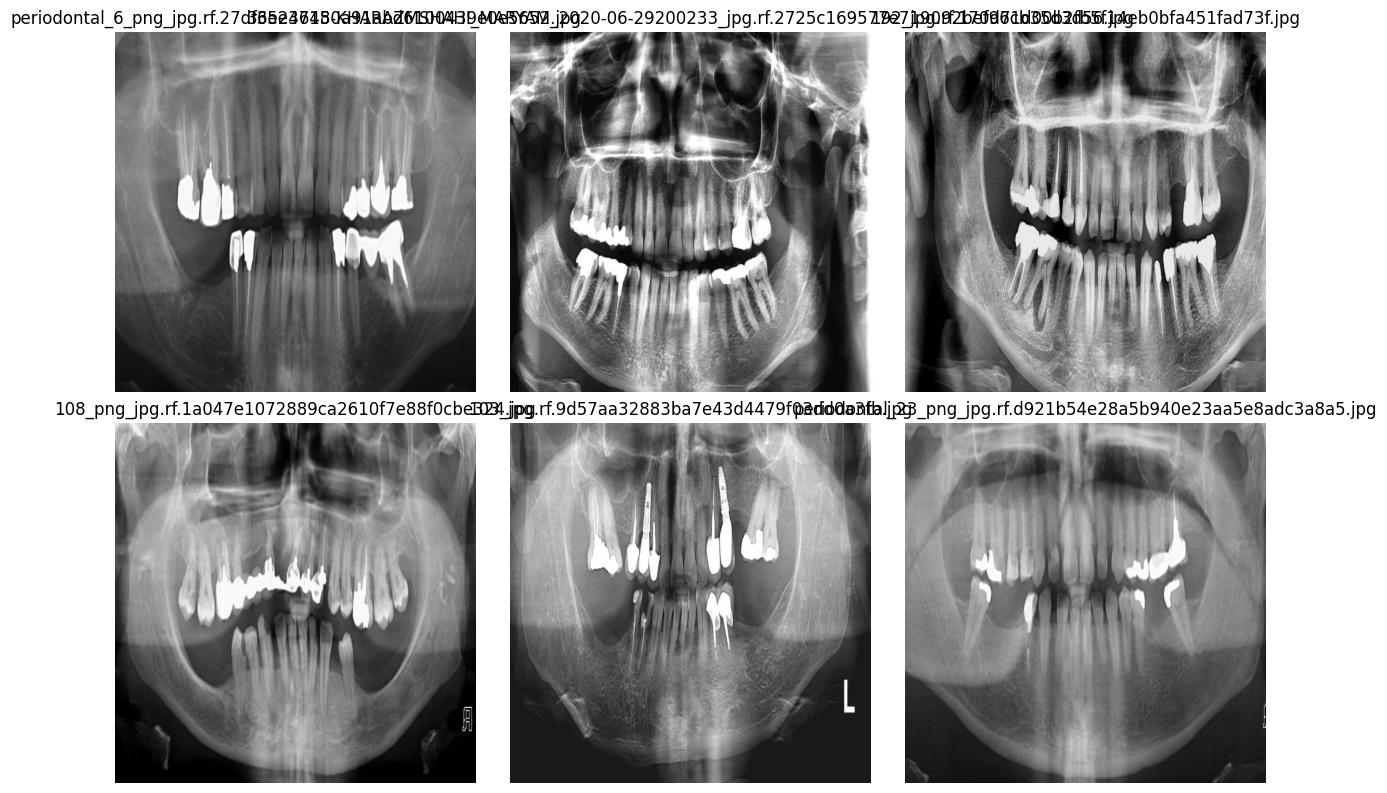

In [29]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# training images path
images_path = "/kaggle/working/Tooth-instance-segmentation-1/train/images"

# random image
num_images = 6
image_files = random.sample(os.listdir(images_path), num_images)

# show images
plt.figure(figsize=(12, 8))
for i, image_file in enumerate(image_files):
    img = mpimg.imread(os.path.join(images_path, image_file))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
# Path to one invalid label file
file_path = "/kaggle/working/Tooth-instance-segmentation-1/train/labels/000dc27f-NAJIB_MARDANLOO_MASUME_2020-07-12185357_jpg.rf.7a9a1d588f63366cf7532f619d77c0f0.txt"

# Read and display the content
with open(file_path, "r") as file:
    content = file.readlines()

print("File content:")
for i, line in enumerate(content, 1):
    print(f"Line {i}: {line.strip()}")


File content:
Line 1: 2 0.691250 0.483039 0.685530 0.487948 0.677902 0.487247 0.675231 0.499875 0.675614 0.516711 0.680191 0.528636 0.687055 0.539861 0.690870 0.553188 0.684386 0.572830 0.695828 0.583353 0.708033 0.573533 0.713755 0.562308 0.716423 0.548278 0.714517 0.520217 0.709558 0.484441 0.700786 0.477427 0.691250 0.483039
Line 2: 2 0.638997 0.518814 0.634802 0.528636 0.629463 0.536352 0.626792 0.553188 0.623741 0.569323 0.625267 0.579144 0.630606 0.592472 0.637091 0.595280 0.640905 0.579845 0.643575 0.576337 0.646627 0.550383 0.649678 0.537756 0.645481 0.523725 0.638997 0.518814
Line 3: 4 0.638234 0.492859 0.637853 0.522322 0.642430 0.520920 0.642430 0.475322 0.643956 0.439545 0.638234 0.492859
Line 4: 0 0.603142 0.541302 0.597973 0.548430 0.593022 0.555558 0.591945 0.564269 0.591945 0.569416 0.592161 0.575752 0.593453 0.581295 0.596036 0.582880 0.599913 0.583275 0.606586 0.582880 0.611108 0.583275 0.615628 0.576544 0.617566 0.571397 0.619720 0.566248 0.621872 0.561495 0.623595 0

In [31]:
import os
from collections import defaultdict

labels_root = "/kaggle/working/Tooth-instance-segmentation-1"
splits = ["train", "valid", "test"]
valid_class_ids = set(range(5))  # IDs: 0 → 4
remap_old_to_new = {}  # optional: fill this if reindex needed

# Track violations
violating_files = defaultdict(list)

for split in splits:
    label_dir = os.path.join(labels_root, split, "labels")
    for file_name in os.listdir(label_dir):
        if file_name.endswith(".txt"):
            file_path = os.path.join(label_dir, file_name)
            with open(file_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    if class_id not in valid_class_ids:
                        violating_files[split].append((file_name, class_id))
                        break  # stop at first invalid class in this file

# Print summary
if any(violating_files.values()):
    print("❌ Found label files with class IDs outside the valid range (0-4):\n")
    for split, files in violating_files.items():
        print(f"Split: {split}")
        for file_name, class_id in files[:5]:  # show sample
            print(f"  - {file_name} → invalid class ID: {class_id}")
        print(f"  Total violating files in {split}: {len(files)}\n")
else:
    print("All label files are clean. No class IDs above 4 found.")


All label files are clean. No class IDs above 4 found.


Class Index | Class Name           | Count
-------------------------------------------
0           | Caries               | 19422
1           | Crown - bridge       | 6272
2           | Filling              | 35652
3           | Post-screw           | 2962
4           | Root Canal Obturation | 22414


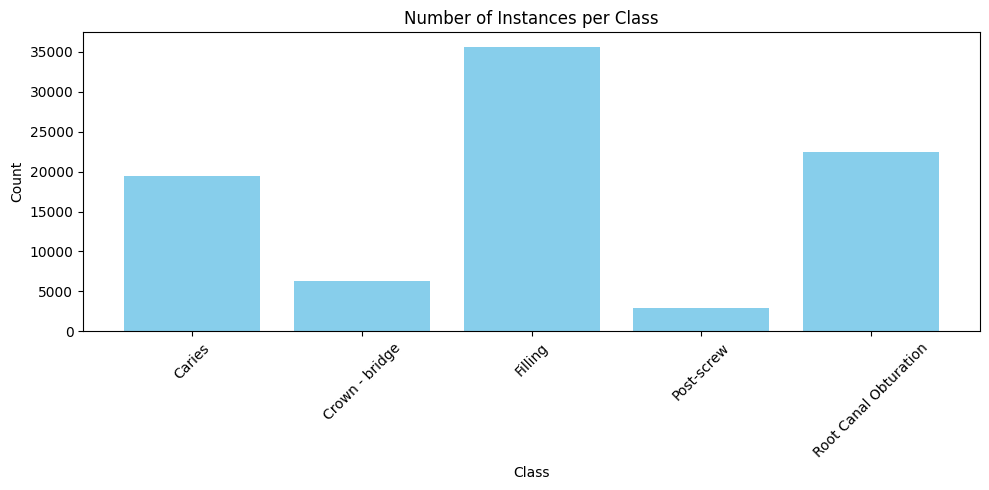

In [33]:
import os
import yaml
from collections import Counter
import matplotlib.pyplot as plt

# Load class names from YAML
yaml_path = "/kaggle/working/Tooth-instance-segmentation-1/data.yaml"
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
class_names = data["names"]

# Count class occurrences in label files
labels_dir = "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
class_counts = Counter()

for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(labels_dir, filename), 'r') as f:
            for line in f:
                cls_id = int(line.strip().split()[0])
                class_counts[cls_id] += 1

# Prepare data
indices = list(range(len(class_names)))
counts = [class_counts.get(i, 0) for i in indices]
labels = [class_names[i] for i in indices]

# Print class info (outside the graph)
print("Class Index | Class Name           | Count")
print("-------------------------------------------")
for i, (label, count) in enumerate(zip(labels, counts)):
    print(f"{i:<11} | {label:<20} | {count}")

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(indices, counts, tick_label=labels, color="skyblue")
plt.title("Number of Instances per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:
def validate_segmentation_labels(label_dir):
    import os

    invalid_files = []
    for filename in os.listdir(label_dir):
        if not filename.endswith(".txt"):
            continue
        path = os.path.join(label_dir, filename)
        with open(path, "r") as f:
            for line_num, line in enumerate(f, 1):
                parts = line.strip().split()
                if len(parts) < 6 or (len(parts) - 1) % 2 != 0:
                    invalid_files.append((filename, line_num, line.strip()))
                    break
    return invalid_files

# Example
invalid = validate_segmentation_labels("/kaggle/working/Tooth-instance-segmentation-1/train/labels")
print(f"Found {len(invalid)} invalid files")
for file, line, content in invalid[:5]:
    print(f"{file} (line {line}): {content}")


Found 0 invalid files


In [38]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [40]:
import torch
torch.cuda.empty_cache()
from ultralytics import YOLO
model = YOLO("/kaggle/input/yolo11s-seg-pt/yolo11s-seg.pt")
model.train(
    data="/kaggle/working/Tooth-instance-segmentation-1/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    lr0=0.001,                   
    optimizer='Adam',            
    weight_decay=0.001,          
    name="yolo11-tooth2-ftuned",
    pretrained=True,
    cos_lr=True,                 
    save=True,                   
    save_period=5                
)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/Tooth-instance-segmentation-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolo11s-seg-pt/yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11-tooth2-ftuned, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1174.3±659.0 MB/s, size: 51.4 KB)


train: Scanning /kaggle/working/Tooth-instance-segmentation-1/train/labels... 5134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5134/5134 [00:05<00:00, 872.35it/s]


train: New cache created: /kaggle/working/Tooth-instance-segmentation-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 707.3±499.0 MB/s, size: 58.1 KB)


val: Scanning /kaggle/working/Tooth-instance-segmentation-1/valid/labels... 728 images, 0 backgrounds, 0 corrupt: 100%|██████████| 728/728 [00:00<00:00, 862.58it/s]

val: New cache created: /kaggle/working/Tooth-instance-segmentation-1/valid/labels.cache


Plotting labels to runs/segment/yolo11-tooth2-ftuned/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.001), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/yolo11-tooth2-ftuned
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100       5.5G      1.651      2.711       1.47      1.135        437        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.81it/s]


                   all        728      12353      0.523      0.424      0.454      0.256      0.411      0.345       0.33      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       6.3G      1.491      2.341      1.084      1.061        341        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]


                   all        728      12353      0.519      0.524       0.51      0.276       0.46      0.471      0.427      0.193

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.34G      1.453      2.232      1.019      1.047        251        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]


                   all        728      12353      0.594      0.558      0.566      0.315      0.554      0.501      0.495      0.229

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.38G      1.416      2.158     0.9784      1.033        425        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]


                   all        728      12353       0.61      0.502      0.525      0.294      0.569      0.444       0.46      0.213

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.43G      1.382      2.126     0.9355      1.021        351        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.91it/s]


                   all        728      12353      0.629      0.607       0.61       0.36      0.574      0.556      0.535      0.261

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.47G       1.35      2.066     0.9097      1.013        348        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]


                   all        728      12353      0.655      0.629       0.64      0.379      0.589      0.581      0.566      0.276

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.51G      1.333      2.034     0.8832      1.005        309        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]

                   all        728      12353      0.663      0.636      0.656      0.389      0.636      0.582      0.594      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.56G      1.314          2     0.8621     0.9951        250        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]


                   all        728      12353      0.605       0.61      0.604      0.355      0.534      0.564      0.529      0.261

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100       6.6G      1.297      1.971     0.8441     0.9952        379        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

                   all        728      12353      0.605      0.541      0.547      0.299      0.535      0.475       0.45      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.64G      1.295      1.972     0.8453     0.9888        409        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]

                   all        728      12353      0.696      0.637      0.665      0.397      0.619      0.589      0.586      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.69G      1.286      1.949     0.8358     0.9875        371        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]


                   all        728      12353      0.663       0.64      0.653      0.388        0.6      0.596      0.577      0.287

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.73G      1.266      1.926     0.8231     0.9824        365        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]

                   all        728      12353      0.714       0.64       0.68      0.412      0.636      0.588      0.597      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.78G       1.27      1.934      0.818     0.9835        450        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]

                   all        728      12353      0.677      0.655      0.671      0.402      0.584      0.588      0.571      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.82G      1.261      1.914     0.8094     0.9803        271        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]


                   all        728      12353      0.698      0.674      0.698       0.42      0.654      0.616      0.621      0.312

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.86G      1.252      1.901     0.8024      0.975        307        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.92it/s]

                   all        728      12353      0.693      0.659      0.687      0.419      0.639      0.611      0.619      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.91G      1.246      1.882     0.7943     0.9747        243        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]


                   all        728      12353      0.734      0.682      0.719      0.439       0.67      0.622       0.64      0.312

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.95G      1.237      1.858     0.7815     0.9735        403        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.87it/s]


                   all        728      12353      0.724      0.687      0.719      0.436      0.656      0.605      0.614      0.305

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.99G      1.222      1.836     0.7728     0.9656        248        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.92it/s]

                   all        728      12353      0.728      0.648      0.701      0.417      0.648      0.578      0.596      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.04G      1.214      1.838     0.7721     0.9672        447        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.92it/s]

                   all        728      12353      0.745      0.675      0.719      0.435      0.679      0.609       0.63      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.08G      1.217       1.82     0.7673     0.9624        184        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

                   all        728      12353      0.725      0.687      0.708      0.437      0.671      0.626      0.638      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.12G      1.206      1.817     0.7614     0.9594        275        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

                   all        728      12353      0.744      0.693      0.738      0.454       0.68      0.633       0.65      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.17G      1.199      1.797     0.7531      0.959        309        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

                   all        728      12353      0.729      0.676      0.718      0.427      0.671      0.595      0.607      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.21G      1.203      1.809     0.7517     0.9602        353        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

                   all        728      12353      0.761      0.705      0.747      0.467      0.703      0.645      0.668      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.25G      1.188      1.784     0.7467     0.9556        328        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:12<00:00,  1.90it/s]

                   all        728      12353      0.754      0.708      0.747       0.47      0.696      0.646      0.661      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100       7.3G      1.192      1.787     0.7454     0.9566        377        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.733      0.709       0.74      0.461       0.66       0.63      0.643      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.34G      1.177      1.771     0.7369     0.9553        277        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]


                   all        728      12353      0.738      0.695      0.731      0.457      0.689      0.657      0.672      0.351

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.38G      1.172       1.76     0.7284     0.9503        324        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]


                   all        728      12353      0.758      0.712      0.757      0.469      0.676       0.64      0.651      0.338

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.59G      1.171      1.754     0.7275      0.951        410        640: 100%|██████████| 321/321 [02:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]

                   all        728      12353       0.76      0.713      0.757      0.478      0.702      0.644      0.673      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.59G      1.171      1.763     0.7329     0.9519        323        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.767      0.735      0.774      0.491      0.698      0.661      0.682      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.59G      1.164      1.737     0.7275     0.9478        359        640: 100%|██████████| 321/321 [02:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.786      0.724      0.779       0.49      0.714      0.663      0.689      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.62G      1.163      1.741     0.7202     0.9466        500        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]

                   all        728      12353      0.768      0.719      0.766      0.485      0.709      0.646      0.677      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.62G      1.153       1.72     0.7123     0.9449        398        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]

                   all        728      12353      0.742      0.712      0.746      0.469      0.697      0.629      0.657      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.62G      1.151      1.719     0.7066     0.9434        295        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]

                   all        728      12353      0.787      0.732      0.783      0.503      0.716      0.662      0.693      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.62G      1.147      1.706     0.7029     0.9423        301        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]

                   all        728      12353      0.769      0.728      0.773      0.489      0.689      0.657      0.672      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.67G      1.139      1.702     0.6991     0.9389        336        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]

                   all        728      12353      0.769      0.725      0.771      0.493      0.714      0.652      0.685      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.72G      1.137      1.692     0.6989     0.9391        291        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.759      0.722      0.766      0.489      0.696      0.666      0.692       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.76G      1.135      1.674     0.6933     0.9364        306        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.782      0.732      0.779      0.502      0.728       0.66      0.688      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.91G      1.133      1.681     0.6933     0.9396        219        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.803      0.732      0.788        0.5      0.729      0.666      0.695      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.99G      1.125      1.674     0.6867     0.9353        280        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

                   all        728      12353      0.799      0.741      0.788      0.506      0.722      0.668      0.695      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.04G      1.114      1.661     0.6804     0.9332        291        640: 100%|██████████| 321/321 [02:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.794      0.757        0.8       0.52      0.747      0.697      0.727      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.12G      1.112       1.66     0.6758     0.9311        362        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]

                   all        728      12353      0.803      0.747      0.802      0.513       0.74       0.67      0.706       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.17G      1.114      1.652     0.6813     0.9334        294        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.803      0.737      0.793      0.501      0.714      0.663      0.688      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.21G      1.108      1.646     0.6739     0.9302        306        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.813      0.749      0.805      0.524      0.742       0.68      0.717       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.25G      1.095      1.624     0.6647      0.926        242        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353        0.8       0.73      0.787      0.506      0.726      0.651      0.684      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.3G      1.098      1.628     0.6679     0.9283        421        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.812      0.759      0.813       0.53      0.764      0.674      0.722      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.34G      1.093      1.618       0.66     0.9259        280        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.826      0.762      0.817      0.533      0.756      0.694      0.729      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.38G       1.08      1.607     0.6576     0.9243        340        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.819      0.745       0.81      0.519       0.74      0.663      0.702      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.43G       1.09      1.616     0.6587     0.9236        291        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.816      0.725       0.79      0.501      0.726      0.652      0.683      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.47G      1.079      1.602     0.6501     0.9206        361        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]

                   all        728      12353      0.832      0.769      0.827      0.546      0.764      0.695      0.733      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.52G       1.08      1.624     0.6543     0.9231        336        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353       0.82      0.746      0.805      0.521      0.744       0.67      0.709      0.371



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.56G      1.075      1.604     0.6522       0.92        216        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.821      0.744       0.81      0.521      0.738      0.669      0.702      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.6G      1.065      1.587     0.6416     0.9204        313        640: 100%|██████████| 321/321 [02:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.808       0.75      0.805      0.515      0.731      0.667      0.694       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.64G      1.069      1.591     0.6426     0.9181        447        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.823      0.758      0.818      0.542      0.763       0.68      0.723      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.82G      1.065      1.573     0.6396     0.9169        351        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.833      0.767      0.827       0.55      0.747      0.699       0.73       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.86G       1.06      1.576      0.639     0.9175        280        640: 100%|██████████| 321/321 [02:23<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]

                   all        728      12353      0.832      0.767      0.824      0.547      0.754      0.683      0.715      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.06G      1.044      1.547     0.6264     0.9129        269        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.805      0.759      0.812      0.523       0.74      0.661      0.702      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100       7.1G      1.044      1.544     0.6256     0.9114        250        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]

                   all        728      12353      0.835      0.775      0.833      0.557      0.765      0.699      0.736      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.15G      1.045      1.547     0.6252     0.9101        319        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.829      0.787      0.839      0.559      0.759      0.711      0.741      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.19G      1.047      1.553     0.6257     0.9114        286        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.837      0.768      0.829      0.544       0.76      0.694       0.73      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.23G      1.034      1.528     0.6196     0.9072        218        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.832      0.771      0.825      0.553      0.767      0.701      0.739      0.399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.28G      1.029      1.518     0.6163     0.9063        298        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.02it/s]

                   all        728      12353      0.832      0.762      0.827      0.547      0.774      0.673      0.725      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.32G      1.021      1.503     0.6065     0.9031        433        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.812      0.749       0.81      0.525      0.734      0.661      0.698      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.36G      1.023      1.512     0.6129     0.9049        323        640: 100%|██████████| 321/321 [02:26<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.832      0.788      0.841      0.569      0.751      0.713      0.742       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.04G      1.019      1.516     0.6098     0.9023        430        640: 100%|██████████| 321/321 [02:26<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]

                   all        728      12353      0.838      0.794      0.846      0.574      0.751      0.719      0.746      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.79G      1.007      1.488     0.5998        0.9        412        640: 100%|██████████| 321/321 [02:26<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]

                   all        728      12353       0.85      0.782      0.843      0.573      0.781      0.713      0.755      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.79G     0.9984      1.477      0.595     0.8997        475        640: 100%|██████████| 321/321 [02:26<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]

                   all        728      12353      0.853      0.795      0.854      0.584      0.778      0.721      0.757      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.79G     0.9991      1.469     0.5937     0.8979        334        640: 100%|██████████| 321/321 [02:25<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.95it/s]

                   all        728      12353      0.831      0.793      0.844      0.567      0.749      0.717      0.741      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.79G     0.9968      1.467     0.5928     0.8972        247        640: 100%|██████████| 321/321 [02:25<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.96it/s]

                   all        728      12353      0.838      0.787      0.845      0.573      0.753      0.711       0.74      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.79G      0.985      1.457     0.5854     0.8949        279        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.841      0.794      0.851       0.58      0.758      0.726      0.751      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.79G     0.9856      1.457     0.5844     0.8964        272        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.841      0.792       0.85      0.579      0.768      0.707      0.746      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.79G     0.9825      1.455     0.5828     0.8941        306        640: 100%|██████████| 321/321 [02:24<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.856       0.79      0.851       0.58      0.779      0.716      0.754      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.83G     0.9821      1.453     0.5827     0.8947        172        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.842       0.81      0.859       0.59      0.767      0.731      0.761      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.88G     0.9707      1.434     0.5751     0.8906        303        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.856      0.797      0.855      0.584      0.777      0.713       0.75      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.92G     0.9642      1.428     0.5734     0.8889        213        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]

                   all        728      12353      0.855      0.807      0.861      0.595      0.775      0.732      0.764       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.96G     0.9649      1.426     0.5686     0.8891        401        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.851       0.81      0.864      0.598       0.78      0.726      0.763       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.01G     0.9583      1.412      0.566     0.8879        302        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.853      0.805       0.86      0.592      0.772      0.723      0.755      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.05G     0.9531       1.41     0.5615     0.8875        349        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.854      0.802      0.861      0.594      0.776      0.724      0.762      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.09G     0.9522      1.411     0.5594     0.8848        259        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.848      0.807       0.86      0.594      0.761      0.729      0.759      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.13G     0.9369      1.386     0.5527      0.882        292        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.857      0.801       0.86      0.596      0.776      0.718      0.758      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.18G     0.9351      1.388     0.5526     0.8817        303        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353       0.86      0.803      0.865      0.602      0.776      0.721      0.759      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.22G     0.9388      1.396     0.5517     0.8821        290        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353       0.87      0.805      0.869      0.605      0.784      0.725      0.766      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.27G     0.9317      1.375     0.5457     0.8795        320        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.864      0.802      0.866      0.601       0.78      0.726      0.765      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.31G     0.9276      1.373     0.5456     0.8805        291        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.99it/s]

                   all        728      12353      0.855      0.809      0.864      0.603      0.785      0.727      0.767      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.35G     0.9217      1.366      0.543     0.8787        351        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.02it/s]

                   all        728      12353      0.864      0.804      0.865      0.601      0.777      0.725      0.763      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.15G     0.9128      1.347     0.5381     0.8779        387        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.854      0.805      0.863      0.599      0.778       0.72       0.76      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100       6.9G     0.9116      1.343     0.5389     0.8759        206        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.855      0.808      0.864      0.602      0.773      0.728      0.762       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       6.9G     0.9179      1.359     0.5407      0.877        327        640: 100%|██████████| 321/321 [02:24<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.854       0.81      0.865      0.603      0.772      0.725      0.759      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100       6.9G     0.9073      1.352     0.5345     0.8756        278        640: 100%|██████████| 321/321 [02:24<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.02it/s]

                   all        728      12353      0.853      0.812      0.865      0.601      0.773      0.724      0.758      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100       6.9G     0.9091      1.346     0.5339     0.8758        340        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.851      0.815      0.867      0.603      0.768      0.731      0.763       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       6.9G     0.9052      1.343     0.5307     0.8747        412        640: 100%|██████████| 321/321 [02:23<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353      0.861      0.818      0.871      0.612      0.775      0.738      0.769      0.437


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.91G     0.8803      1.329     0.5195     0.8836        227        640: 100%|██████████| 321/321 [02:19<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]

                   all        728      12353      0.857      0.817      0.869      0.606      0.779      0.735      0.767      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.95G     0.8736      1.322     0.5155     0.8819        293        640: 100%|██████████| 321/321 [02:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.866      0.815      0.871      0.611      0.786      0.735      0.772      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100         7G     0.8718      1.318     0.5126     0.8795        250        640: 100%|██████████| 321/321 [02:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.867      0.813      0.871      0.608      0.783      0.732      0.767      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.04G     0.8674      1.316       0.51     0.8797        215        640: 100%|██████████| 321/321 [02:19<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.865      0.815       0.87      0.608      0.788       0.73      0.768      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.08G     0.8598      1.305     0.5051     0.8773        248        640: 100%|██████████| 321/321 [02:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.868      0.813      0.869      0.607      0.787      0.729      0.765      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.13G     0.8645      1.313     0.5087     0.8777        244        640: 100%|██████████| 321/321 [02:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.867      0.818       0.87       0.61      0.783      0.732      0.768      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.17G      0.858      1.301     0.5055     0.8763        226        640: 100%|██████████| 321/321 [02:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.869      0.816      0.872       0.61      0.783      0.733      0.769      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.21G     0.8564        1.3     0.5045     0.8762        267        640: 100%|██████████| 321/321 [02:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  1.98it/s]

                   all        728      12353       0.87      0.815      0.872      0.611      0.782      0.732      0.768      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.25G     0.8578      1.302     0.5044     0.8766        259        640: 100%|██████████| 321/321 [02:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.02it/s]

                   all        728      12353       0.88       0.81      0.873      0.613      0.793      0.729      0.771      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       7.3G     0.8581      1.304     0.5047     0.8777        206        640: 100%|██████████| 321/321 [02:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]

                   all        728      12353      0.879      0.812      0.874      0.612      0.793      0.728       0.77      0.434



100 epochs completed in 4.337 hours.
Optimizer stripped from runs/segment/yolo11-tooth2-ftuned/weights/last.pt, 20.5MB
Optimizer stripped from runs/segment/yolo11-tooth2-ftuned/weights/best.pt, 20.5MB

Validating runs/segment/yolo11-tooth2-ftuned/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,068,751 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/23 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 1/23 [00:00<00:10,  2.16it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▊         | 2/23 [00:01<00:14,  1.45it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:14<00:00,  1.63it/s]
invalid value encountered in less
invalid value encountered in less


                   all        728      12353       0.88      0.811      0.874      0.613      0.796      0.727      0.771      0.436
                Caries        495       2794      0.862       0.48      0.658       0.32      0.736      0.394      0.516       0.21
        Crown - bridge        291        971      0.934      0.984      0.989      0.834      0.931      0.973      0.976      0.673
               Filling        660       4998      0.949      0.956      0.981      0.819      0.925      0.927      0.957      0.657
            Post-screw        230        479      0.826      0.772       0.85      0.502      0.717      0.653      0.703      0.307
 Root Canal Obturation        550       3111      0.826       0.86      0.892       0.59       0.67      0.686      0.701      0.331
Speed: 0.2ms preprocess, 7.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/yolo11-tooth2-ftuned


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac61e073790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,  

In [41]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,068,751 parameters, 0 gradients, 35.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 855.9±337.2 MB/s, size: 56.8 KB)


val: Scanning /kaggle/working/Tooth-instance-segmentation-1/valid/labels.cache... 728 images, 0 backgrounds, 0 corrupt: 100%|██████████| 728/728 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/46 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/46 [00:00<00:32,  1.39it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/46 [00:01<00:31,  1.40it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:18<00:00,  2.54it/s]
invalid value encountered in less
invalid value encountered in less


                   all        728      12353      0.879      0.813      0.874      0.617       0.79      0.718       0.76      0.424
                Caries        495       2794      0.861      0.486      0.659      0.322      0.725      0.382      0.497        0.2
        Crown - bridge        291        971      0.933      0.985      0.989      0.835      0.932      0.973      0.976      0.666
               Filling        660       4998      0.949      0.957       0.98      0.824       0.92      0.921      0.952      0.641
            Post-screw        230        479      0.828      0.775       0.85      0.507      0.711      0.641      0.685      0.295
 Root Canal Obturation        550       3111      0.825      0.862      0.891      0.596      0.664      0.672      0.688      0.317
Speed: 0.6ms preprocess, 14.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/yolo11-tooth2-ftuned2
ultralytics.utils.metrics.SegmentMetrics object with attributes:

a

In [47]:
import pandas as pd

# Updated evaluation results based on the provided table
data = {
    "Class": [
        "all", "Caries", "Crown - bridge", "Filling",
        "Post-screw", "Root Canal Obturation"
    ],
    "Images": [728, 495, 291, 660, 230, 550],
    "Instances": [12353, 2794, 971, 4998, 479, 3111],
    "Box(P)": [0.879, 0.861, 0.933, 0.949, 0.828, 0.825],
    "Box(R)": [0.813, 0.486, 0.985, 0.957, 0.775, 0.862],
    "mAP50": [0.874, 0.659, 0.989, 0.980, 0.850, 0.891],
    "mAP50-95": [0.617, 0.322, 0.835, 0.824, 0.507, 0.596],
    "Mask(P)": [0.790, 0.725, 0.932, 0.920, 0.711, 0.664],
    "Mask(R)": [0.718, 0.382, 0.973, 0.921, 0.641, 0.672],
    "Mask_mAP50": [0.760, 0.497, 0.976, 0.952, 0.685, 0.688],
    "Mask_mAP50-95": [0.424, 0.200, 0.666, 0.641, 0.295, 0.317]
}

# Create DataFrame and display it
df = pd.DataFrame(data)
pd.set_option('display.precision', 3)
display(df)


Class  Images  Instances  Box(P)  Box(R)  mAP50  mAP50-95  \
0                    all     728      12353   0.879   0.813  0.874     0.617   
1                 Caries     495       2794   0.861   0.486  0.659     0.322   
2         Crown - bridge     291        971   0.933   0.985  0.989     0.835   
3                Filling     660       4998   0.949   0.957  0.980     0.824   
4             Post-screw     230        479   0.828   0.775  0.850     0.507   
5  Root Canal Obturation     550       3111   0.825   0.862  0.891     0.596   

   Mask(P)  Mask(R)  Mask_mAP50  Mask_mAP50-95  
0    0.790    0.718       0.760          0.424  
1    0.725    0.382       0.497          0.200  
2    0.932    0.973       0.976          0.666  
3    0.920    0.921       0.952          0.641  
4    0.711    0.641       0.685          0.295  
5    0.664    0.672       0.688          0.317

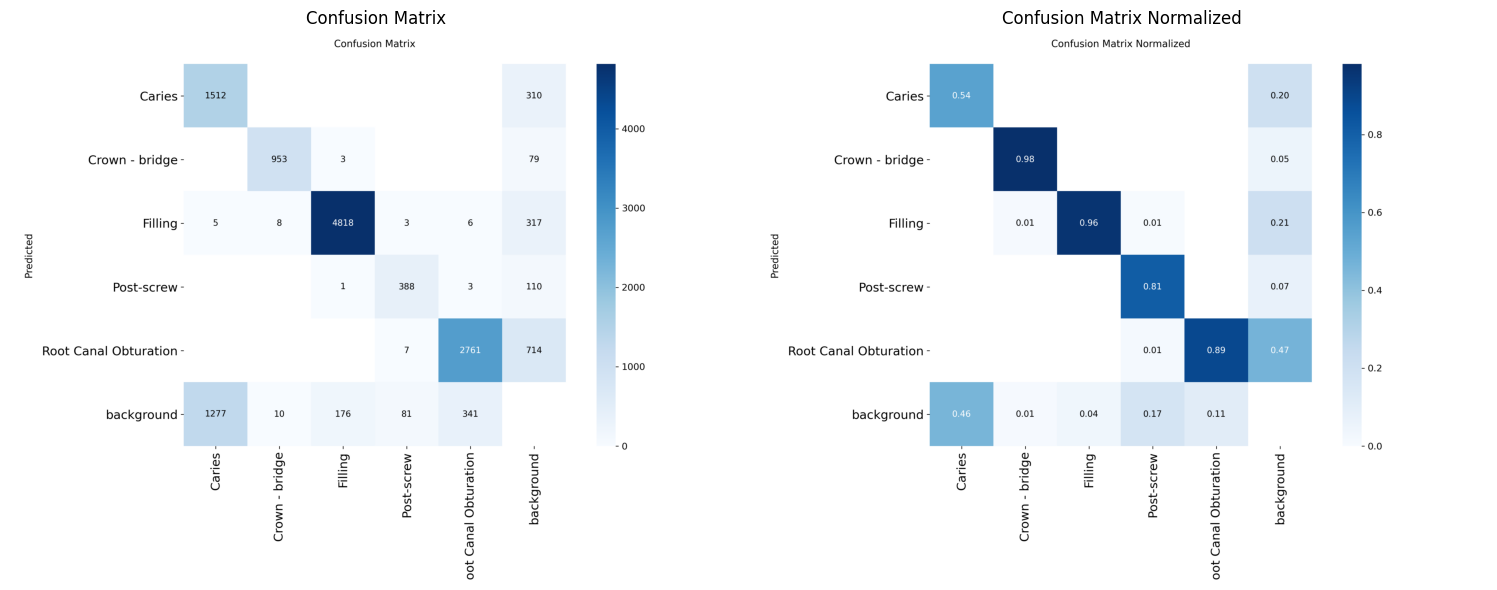

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

paths = [
    "/kaggle/working/runs/segment/yolo11-tooth2-ftuned2/confusion_matrix.png",
    "/kaggle/working/runs/segment/yolo11-tooth2-ftuned2/confusion_matrix_normalized.png"
]

titles = [
    "Confusion Matrix",
    "Confusion Matrix Normalized"
]

plt.figure(figsize=(30, 15))
for i, (path, title) in enumerate(zip(paths, titles)):
    img = mpimg.imread(path)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

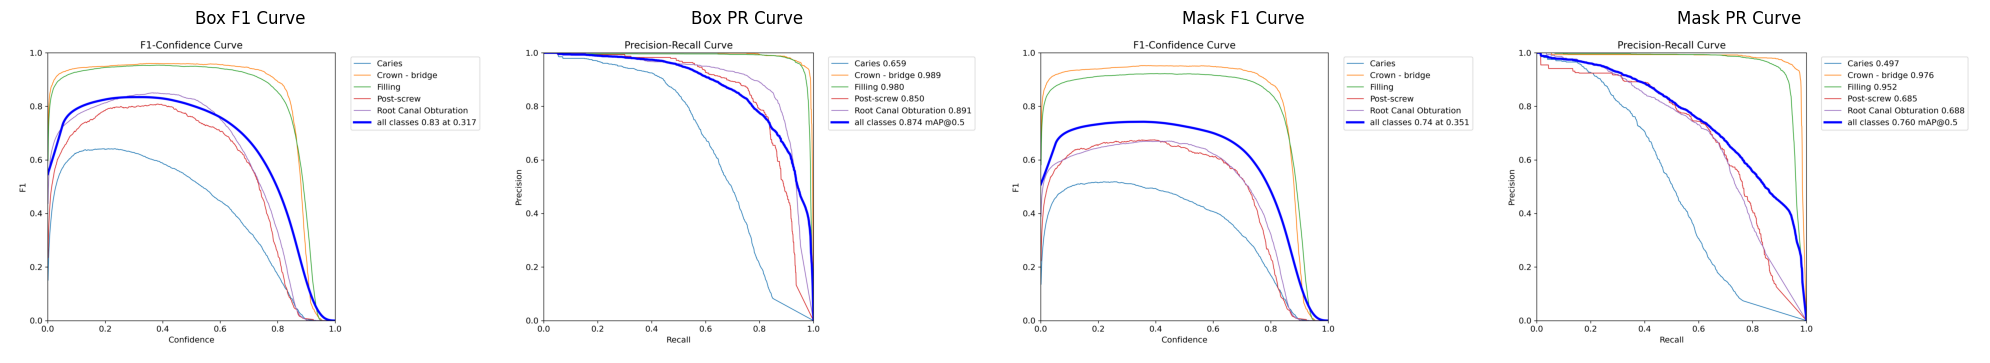

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

paths = [
    "/kaggle/working/runs/segment/yolo11-tooth2-ftuned2/BoxF1_curve.png",
    "/kaggle/working/runs/segment/yolo11-tooth2-ftuned2/BoxPR_curve.png",
    "/kaggle/working/runs/segment/yolo11-tooth2-ftuned2/MaskF1_curve.png",
    "/kaggle/working/runs/segment/yolo11-tooth2-ftuned2/MaskPR_curve.png"
]

titles = [
    "Box F1 Curve",
    "Box PR Curve",
    "Mask F1 Curve",
    "Mask PR Curve"
]

plt.figure(figsize=(20, 5))
for i, (path, title) in enumerate(zip(paths, titles)):
    img = mpimg.imread(path)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()


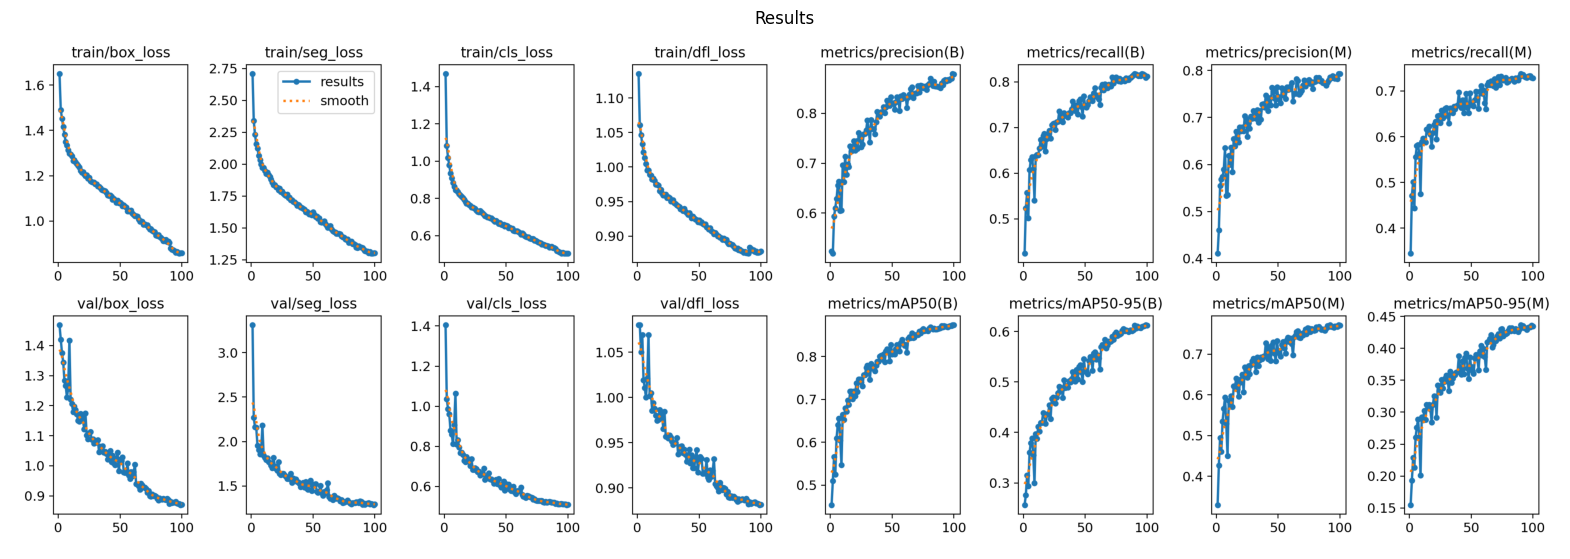

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_path = "/kaggle/working/runs/segment/yolo11-tooth2-ftuned/results.png"


img = mpimg.imread(img_path)
plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.axis('off')  
plt.title("Results")
plt.show()



image 1/1 /kaggle/working/Tooth-instance-segmentation-1/valid/images/105_jpg.rf.f9c70324a3ca3cbbd9fd85df9c3c119b.jpg: 640x640 15 Fillings, 7 Root Canal Obturations, 20.2ms
Speed: 1.7ms preprocess, 20.2ms inference, 15.2ms postprocess per image at shape (1, 3, 640, 640)


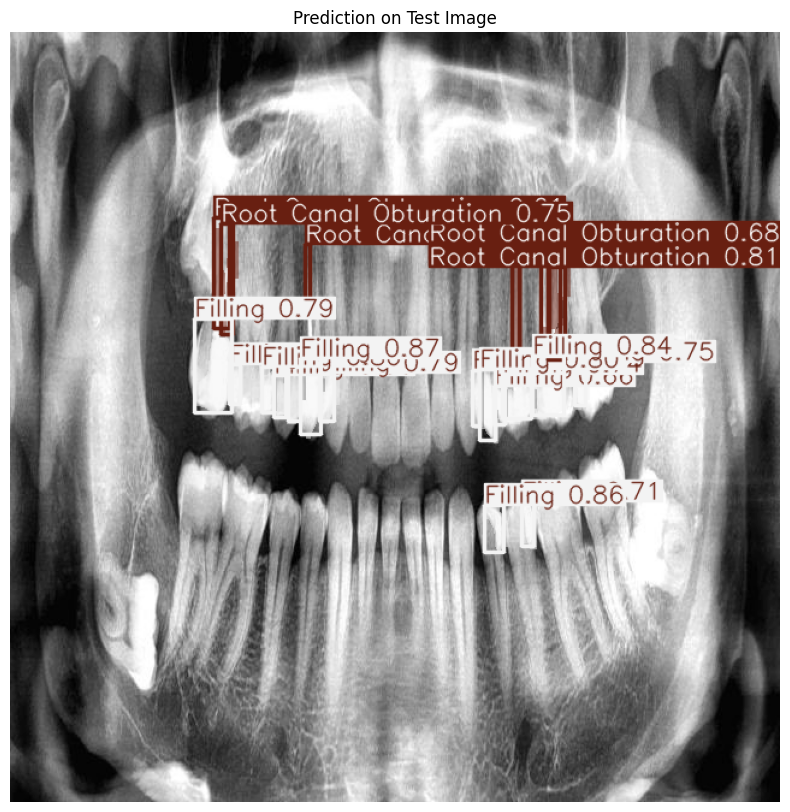

In [42]:
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt")

# Select a test image
image_path = "/kaggle/working/Tooth-instance-segmentation-1/valid/images/105_jpg.rf.f9c70324a3ca3cbbd9fd85df9c3c119b.jpg"

# Run inference
results = model.predict(source=image_path, save=False, conf=0.5)

# Display the result
result_image = results[0].plot()  # Returns the image with segmentation masks

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title("Prediction on Test Image")
plt.show()



image 1/1 /kaggle/working/Tooth-instance-segmentation-1/test/images/109_jpg.rf.b7de1032a682c82e071af58a0f4b6bac.jpg: 640x640 1 Filling, 2 Root Canal Obturations, 20.2ms
Speed: 1.7ms preprocess, 20.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


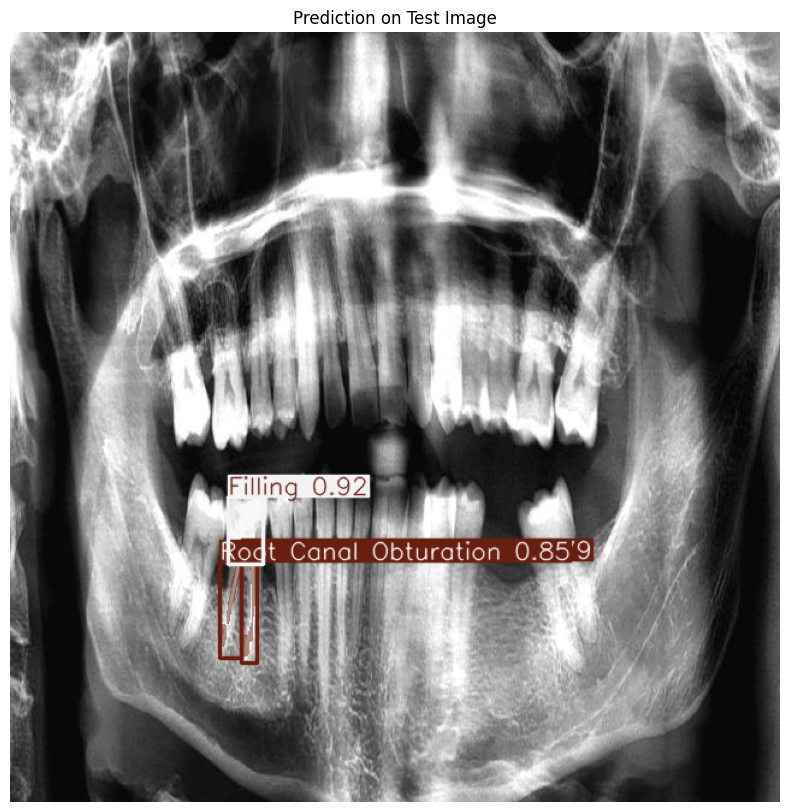

In [43]:
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt")

# Select a test image
image_path = "/kaggle/working/Tooth-instance-segmentation-1/test/images/109_jpg.rf.b7de1032a682c82e071af58a0f4b6bac.jpg"

# Run inference
results = model.predict(source=image_path, save=False, conf=0.5)

# Display the result
result_image = results[0].plot()  # Returns the image with segmentation masks

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title("Prediction on Test Image")
plt.show()



image 1/1 /kaggle/working/Tooth-instance-segmentation-1/test/images/111_jpg.rf.7f59313298c867b5fa880e659ee45e95.jpg: 640x640 14 Fillings, 2 Post-screws, 1 Root Canal Obturation, 20.2ms
Speed: 1.5ms preprocess, 20.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


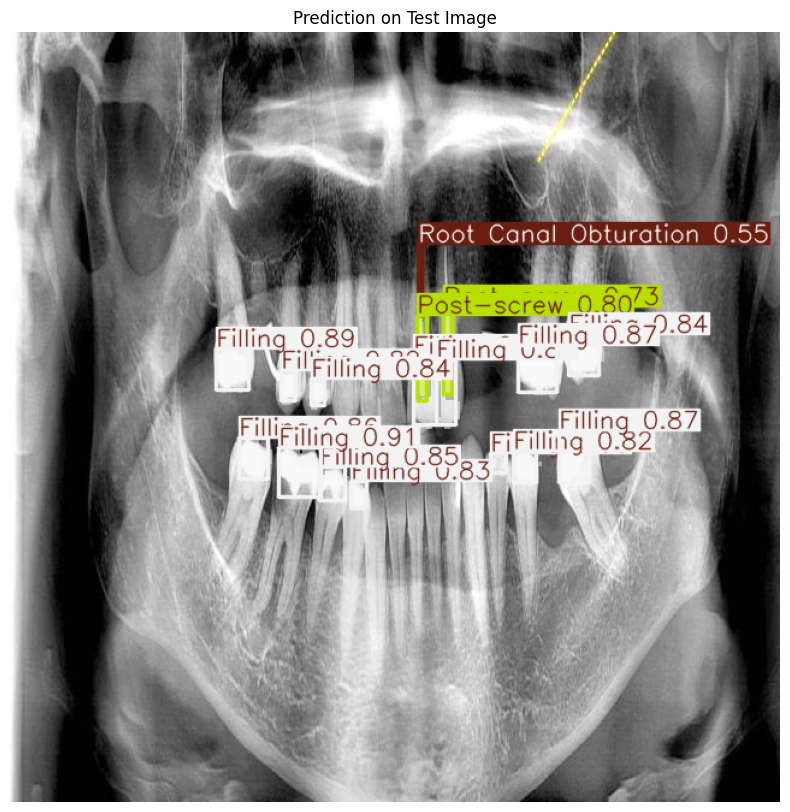

In [44]:
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt")

# Select a test image
image_path = "/kaggle/working/Tooth-instance-segmentation-1/test/images/111_jpg.rf.7f59313298c867b5fa880e659ee45e95.jpg"

# Run inference
results = model.predict(source=image_path, save=False, conf=0.5)

# Display the result
result_image = results[0].plot()  # Returns the image with segmentation masks

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title("Prediction on Test Image")
plt.show()



image 1/1 /kaggle/working/Tooth-instance-segmentation-1/test/images/115_jpg.rf.2c6b36ac1c50c9d62a50835874c92c48.jpg: 640x640 1 Caries, 3 Fillings, 20.2ms
Speed: 1.4ms preprocess, 20.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


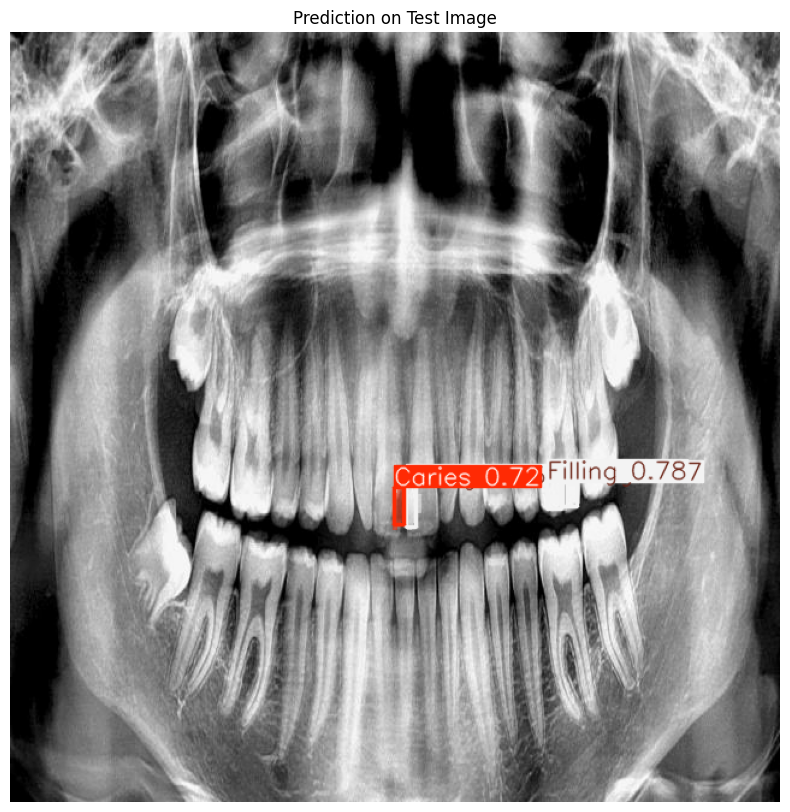

In [45]:
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt")

# Select a test image
image_path = "/kaggle/working/Tooth-instance-segmentation-1/test/images/115_jpg.rf.2c6b36ac1c50c9d62a50835874c92c48.jpg"

# Run inference
results = model.predict(source=image_path, save=False, conf=0.5)

# Display the result
result_image = results[0].plot()  # Returns the image with segmentation masks

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title("Prediction on Test Image")
plt.show()



image 1/1 /kaggle/working/Tooth-instance-segmentation-1/test/images/128_jpg.rf.8137d1733ab7c23b56c4a9adf596692a.jpg: 640x640 4 Cariess, 3 Fillings, 2 Root Canal Obturations, 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


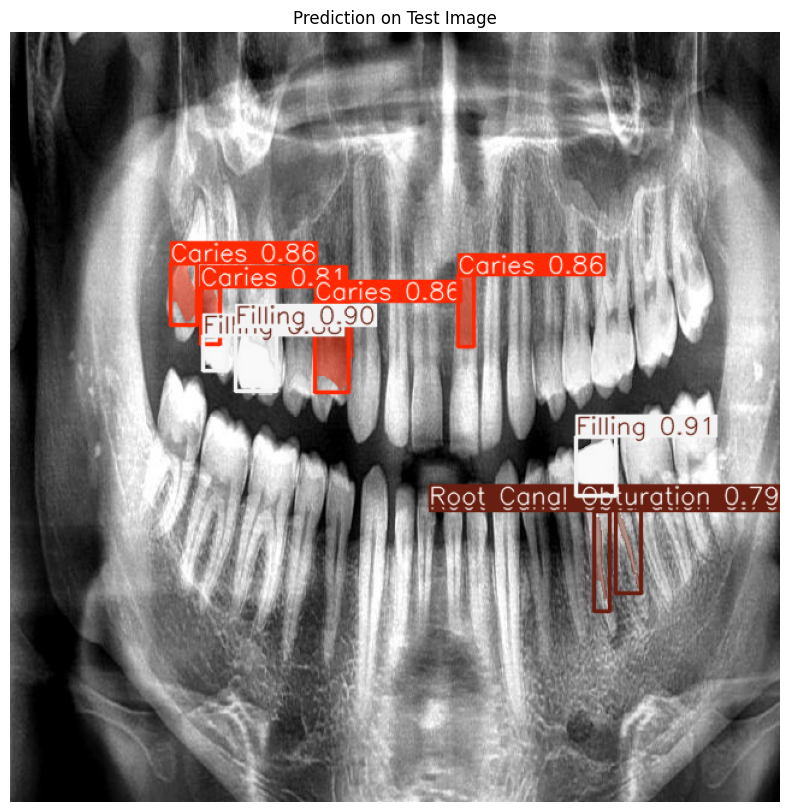

In [55]:
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt")

# Select a test image
image_path = "/kaggle/working/Tooth-instance-segmentation-1/test/images/128_jpg.rf.8137d1733ab7c23b56c4a9adf596692a.jpg"

# Run inference
results = model.predict(source=image_path, save=False, conf=0.5)

# Display the result
result_image = results[0].plot()  # Returns the image with segmentation masks

plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.title("Prediction on Test Image")
plt.show()



image 1/1 /kaggle/working/Tooth-instance-segmentation-1/test/images/38c4e216-Norozi_syavazan_Atefeh_2022-06-12142626_jpg.rf.b0592eb314b0d79ab5258ac21b1e7c7f.jpg: 640x640 6 Cariess, 20.2ms
Speed: 1.5ms preprocess, 20.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


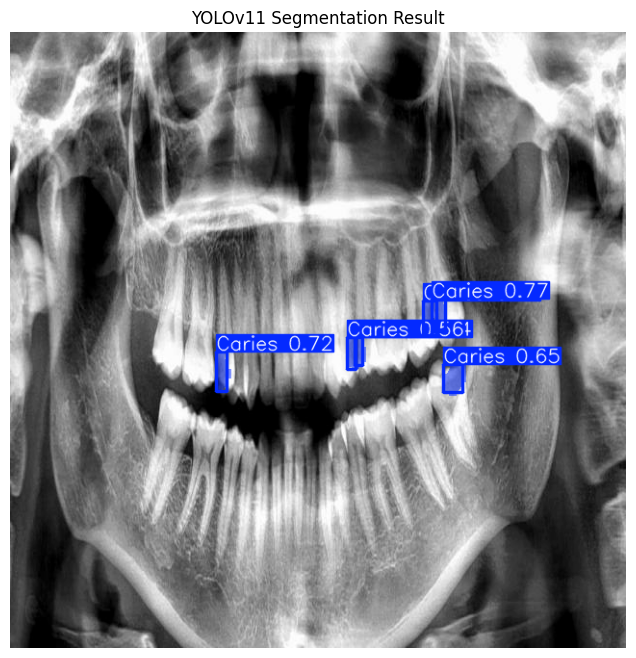

In [60]:
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO

model = YOLO('/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt')

img_path = '/kaggle/working/Tooth-instance-segmentation-1/test/images/38c4e216-Norozi_syavazan_Atefeh_2022-06-12142626_jpg.rf.b0592eb314b0d79ab5258ac21b1e7c7f.jpg'

results = model(img_path)

res_plotted = results[0].plot()

img_bgr = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 8))
plt.imshow(img_bgr)
plt.axis('off')
plt.title("YOLOv11 Segmentation Result")
plt.show()



0: 640x640 4 Cariess, 3 Fillings, 2 Root Canal Obturations, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


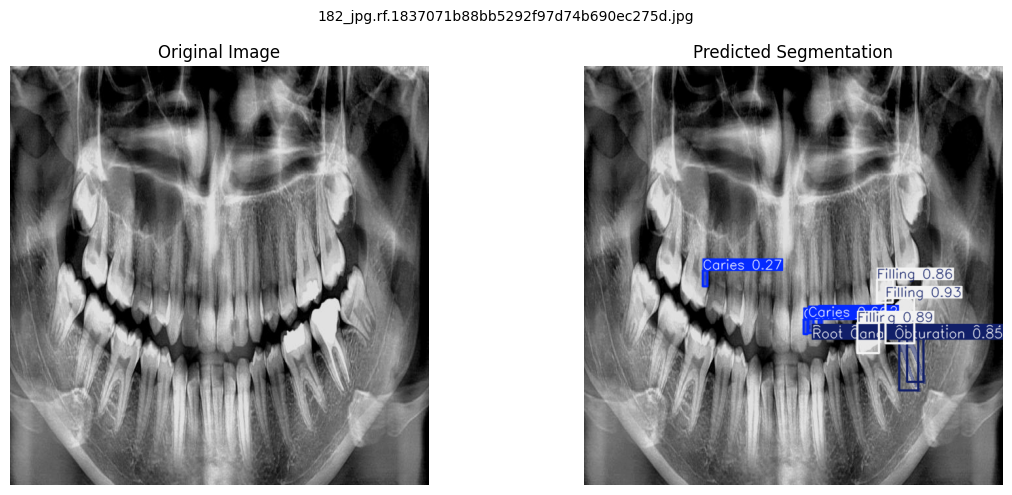


0: 640x640 7 Cariess, 6 Fillings, 10 Root Canal Obturations, 20.3ms
Speed: 1.5ms preprocess, 20.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


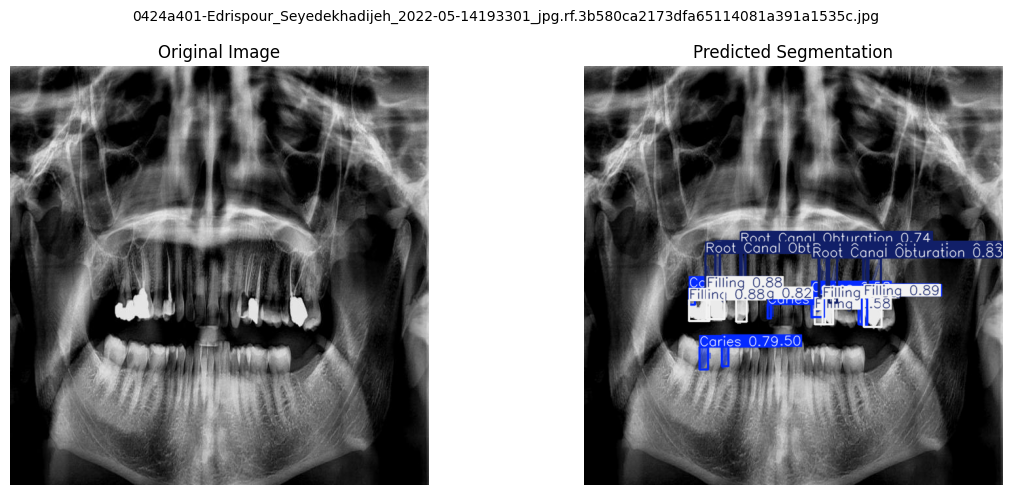


0: 640x640 7 Crown - bridges, 7 Fillings, 2 Post-screws, 13 Root Canal Obturations, 20.3ms
Speed: 1.4ms preprocess, 20.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


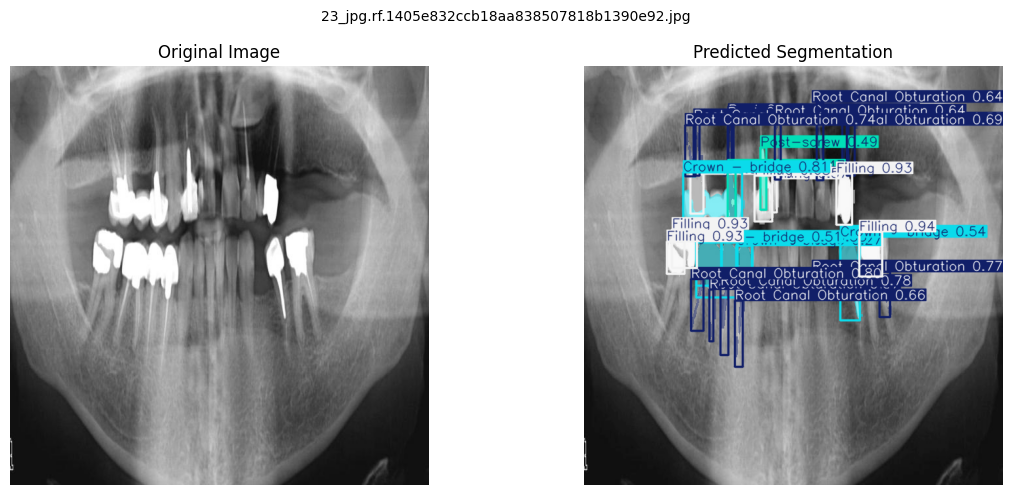


0: 640x640 4 Cariess, 5 Crown - bridges, 10 Fillings, 3 Post-screws, 9 Root Canal Obturations, 20.2ms
Speed: 1.4ms preprocess, 20.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


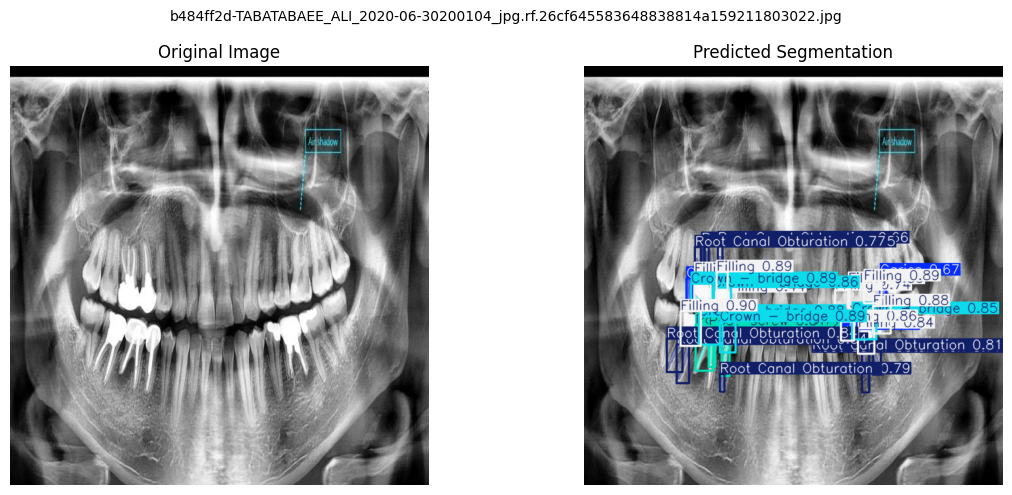


0: 640x640 5 Cariess, 3 Crown - bridges, 5 Fillings, 1 Post-screw, 2 Root Canal Obturations, 20.3ms
Speed: 1.5ms preprocess, 20.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


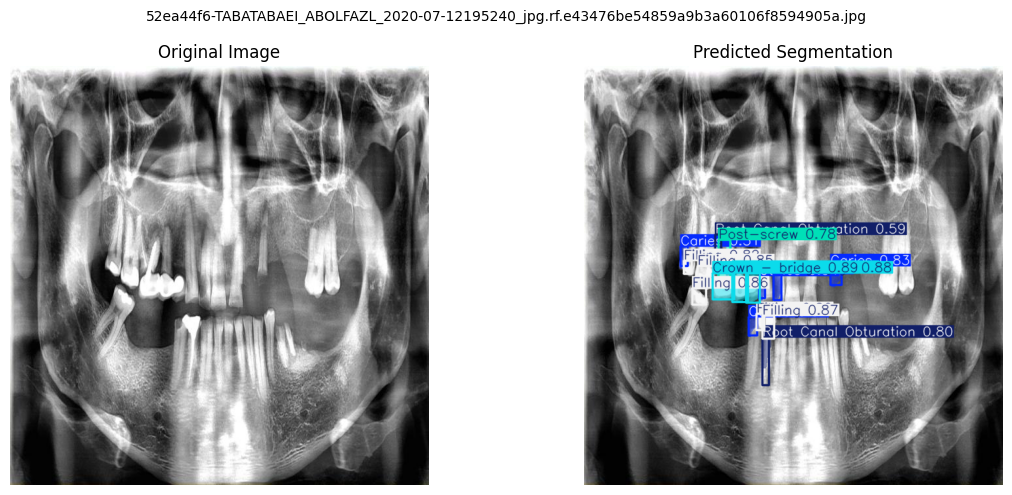

In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image

# Load your trained segmentation model
model = YOLO("/kaggle/working/runs/segment/yolo11-tooth2-ftuned/weights/best.pt")

# Path to validation images
val_images_path = "/kaggle/working/Tooth-instance-segmentation-1/valid/images"

# Get a few sample images (make sure they're images)
sample_imgs = [f for f in os.listdir(val_images_path) if f.endswith((".jpg", ".png"))][:5]

# Display original and predicted side-by-side
for img_name in sample_imgs:
    img_path = os.path.join(val_images_path, img_name)
    image = Image.open(img_path).convert("RGB")

    # Run prediction
    pred_result = model.predict(image, conf=0.25)[0].plot()

    # Convert both original and prediction for plotting
    orig_np = np.array(image)
    pred_np = cv2.cvtColor(pred_result, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_np)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.suptitle(img_name, fontsize=10)
    plt.tight_layout()
    plt.show()
